# AMATH797 PSet4 David Lieberman

In [0]:
import os
import numpy as np
import sklearn
from sklearn import manifold
from sklearn import datasets
from sklearn.datasets import fetch_openml
from sklearn.utils import check_random_state
from sklearn.cluster import KMeans
from sklearn.neighbors import kneighbors_graph
from sklearn.cluster import SpectralClustering
np.random.seed(0)

import networkx as nx
import scipy
from scipy.sparse import csgraph

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

# from google.colab import drive
# drive.mount('/content/drive')
# cd 'drive/My Drive/2020S_AMATH797/PSet3'
os.chdir(os.path.expanduser(os.sep.join(["/mnt","c","Users","darkg","Desktop", "Homework Scans", "2020S_AMATH797", "PSet4"])))
# os.chdir(os.path.expanduser(os.sep.join(["~","Desktop", "Homework Scans", "2020S_AMATH797", "PSet3"])))

## Problem 2

### Part A

**Isomap** is a non-linear dimensionality reduction method method with the goal of preserving the geodesic distance in the low-dimensional embedding. We use the k nearest neighbors algorithm to construct a neighborhood graph with the edge length as the Euclidean distance, and by computing the shortest path between two nodes we can approximate the geodesic distance on the manifold. The last step is to apply multi-dimensional scaling by taking the eigendecomposition of the geodesic proximity matrix to obtain the low dimensional embedding of the data.
We try to minimize the "Strain" cost function in classical MDS:
$$\min_{x_1, \dots, x_M} \left(\frac{\sum_{i, j}\left(b_{i j}-\left\langle x_{i}, x_{j}\right\rangle\right)^{2}}{\sum_{i, j} b_{i j}^{2}}\right)^{1 / 2}$$
or the "Stress" in metric MDS:
$$\min_{x_1, \dots, x_M} \left(\sum_{i < j} \left(\lVert x_i - x_j \rVert - d_{i,j}\right)^2\right)^{1/2}$$

which is just the residual sum of squares.

**t-SNE** is a non-linear dimensionality reduction method that constructs probability distributions over high dimensional objects such that similar objects are modeled as being close while dissimilar objects are modeled as being far away, with high probability. First, in high-dimensional space, t-SNE uses the Gaussian distribution to define relationships between the points, then recreates the probability distribution in low-dimensional space using the t-distribution with 1 degree of freedom (Cauchy). This helps to combat the curse of dimensionality often encountered when going from high to low-dimensional data, where moderate spacing in high dimensions clumps dramatically in lower dimensions. t-SNE uses gradient descent to obtain locations of the mapped points in lower-dimensional space by minimizing the KL divergence between the Gaussian and the t-distribution:

$$\mathrm{KL}(P \| Q)=\sum_{i \neq j} p_{i j} \log \frac{p_{i j}}{q_{i j}}$$

### Part B

In [2]:
# Vanilla
vanilla_swiss_roll, vanilla_color = datasets.make_swiss_roll(n_samples=10000)
vanilla_swiss_roll = vanilla_swiss_roll - np.mean(vanilla_swiss_roll, axis=0)

# Hole
hole_swiss_roll, hole_color = datasets.make_swiss_roll(n_samples=10000)
hole_swiss_roll = hole_swiss_roll - np.mean(hole_swiss_roll, axis=0)
keep = np.array([], dtype=bool)
for point in zip(hole_swiss_roll):
  keep = np.append(keep, np.linalg.norm(point[0][0:2]) > 4)

hole_swiss_roll = hole_swiss_roll[keep, ...]
hole_color = hole_color[keep]

# Noise
noisy_swiss_roll, noisy_color = datasets.make_swiss_roll(n_samples=10000, noise=1.0)
noisy_swiss_roll = noisy_swiss_roll - np.mean(noisy_swiss_roll, axis=0)

fig = plt.figure(figsize=(20, 8))
ax = fig.add_subplot(1, 3, 1, projection='3d')
ax.scatter(vanilla_swiss_roll[:, 0], vanilla_swiss_roll[:, 1], vanilla_swiss_roll[:, 2], c=vanilla_color, cmap='Spectral', s=8)
ax.title.set_text("Vanilla Swiss Roll")

ax = fig.add_subplot(1, 3, 2, projection='3d')
ax.scatter(hole_swiss_roll[:, 0], hole_swiss_roll[:, 1], hole_swiss_roll[:, 2], c=hole_color, cmap='Spectral', s=8)
ax.title.set_text("Swiss Roll with Hole (r=1 centered at origin)")

ax = fig.add_subplot(1, 3, 3, projection='3d')
ax.scatter(noisy_swiss_roll[:, 0], noisy_swiss_roll[:, 1], noisy_swiss_roll[:, 2], c=noisy_color, cmap='Spectral', s=8)
ax.title.set_text("Noisy Swiss Roll ($\sigma = 1$)")

fig.suptitle("Original Data", fontsize=22)
plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [3]:
# Isomap Vanilla
Vanilla_Iso = manifold.Isomap(n_neighbors=30, n_components=2).fit_transform(vanilla_swiss_roll)

# Isomap Hole
Hole_Iso = manifold.Isomap(n_neighbors=30, n_components=2).fit_transform(hole_swiss_roll)

# Isomap Noisy
Noisy_Iso = manifold.Isomap(n_neighbors=30, n_components=2).fit_transform(noisy_swiss_roll)

fig = plt.figure(figsize=(20, 8))
ax = fig.add_subplot(1, 3, 1)
ax.scatter(Vanilla_Iso[:, 0], Vanilla_Iso[:, 1], c=vanilla_color, cmap='Spectral', s=8)
ax.title.set_text("Vanilla Swiss Roll Embedding")

ax = fig.add_subplot(1, 3, 2)
ax.scatter(Hole_Iso[:, 0], Hole_Iso[:, 1], c=hole_color, cmap='Spectral', s=8)
ax.title.set_text("Swiss Roll with Hole Embedding")

ax = fig.add_subplot(1, 3, 3)
ax.scatter(Noisy_Iso[:, 0], Noisy_Iso[:, 1], c=noisy_color, cmap='Spectral', s=8)
ax.title.set_text("Noisy Swiss Roll Embedding")

fig.suptitle("Isomap", fontsize=22)
plt.show()

Output hidden; open in https://colab.research.google.com to view.

The isomap did an excellent job here at "unrolling" our swiss roll dataset into two dimensions, and both keeping connected neighborhoods of points together and preserving the geodesic distance along the manifold. We see in the noisy swiss roll embedding this geodesic distance preservation might have slightly lapsed as the red/orange points are very far from the blue points on the manifold while they appear close here in Euclidean space, but the spiral/manifold geometric structure is very well preserved, so we retain good intuition regarding the distance geodesic distance.

In [4]:
# t-SNE Vanilla
Vanilla_tSNE = manifold.TSNE(n_components=2, perplexity=200, learning_rate=250, n_iter=2500, init='random').fit_transform(vanilla_swiss_roll)

# t-SNE Hole
Hole_tSNE = manifold.TSNE(n_components=2, perplexity=95, init='random').fit_transform(hole_swiss_roll)

# t-SNE Noisy
Noisy_tSNE = manifold.TSNE(n_components=2, perplexity=150, learning_rate=250, n_iter=2000, init='random').fit_transform(noisy_swiss_roll)

fig = plt.figure(figsize=(20, 8))
ax = fig.add_subplot(1, 3, 1)
ax.scatter(Vanilla_tSNE[:, 0], Vanilla_tSNE[:, 1], c=vanilla_color, cmap='Spectral', s=8)
ax.title.set_text("Vanilla Swiss Roll Embedding")

ax = fig.add_subplot(1, 3, 2)
ax.scatter(Hole_tSNE[:, 0], Hole_tSNE[:, 1], c=hole_color, cmap='Spectral', s=8)
ax.title.set_text("Swiss Roll with Hole Embedding")

ax = fig.add_subplot(1, 3, 3)
ax.scatter(Noisy_tSNE[:, 0], Noisy_tSNE[:, 1], c=noisy_color, cmap='Spectral', s=8)
ax.title.set_text("Noisy Swiss Roll Embedding")

fig.suptitle("t-SNE", fontsize=22)
plt.show()

Output hidden; open in https://colab.research.google.com to view.

The swiss roll is a canonically pathological distribtuion for t-SNE, however we see here that with some tuning of the parameters, we still manage to retain decent results. Although there is some tearing along the region of the manifold with the high curvature, for the most part, the data remains connected in a single cluster. We note that the swiss roll with hole was particularly successful as it gives a good visualization of where the hole was excised from the dataset. Although there are a few scattered datapoints in the noisy swiss roll embedding, t-SNE was largely successful in keeping neighboring points in the manifold close to one another in the embedding, while keep distant points far apart.

### Part C

In [0]:
MNIST, labels = fetch_openml('mnist_784', version=1, return_X_y=True)

random_state = check_random_state(0)
permutation = random_state.permutation(MNIST.shape[0])
MNIST = MNIST[permutation]
labels = labels[permutation]

MNIST = MNIST[:6000, :]
labels = labels[:6000]
labels = [int(label) for label in labels]

groups = []
for i in np.arange(10):
  groups.append(np.where(labels == i))

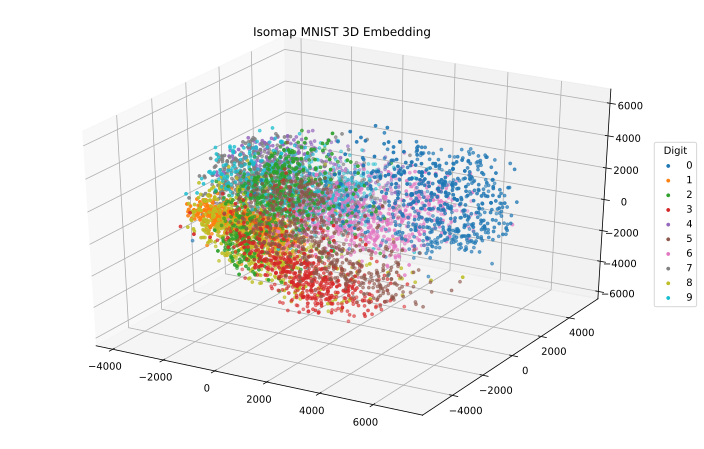

In [6]:
MNIST_Iso = manifold.Isomap(n_neighbors=15, n_components=3).fit_transform(MNIST)

fig = plt.figure(figsize=(12,8))
ax = plt.axes(projection='3d')
for idx, group in enumerate(groups):
  ax.scatter(MNIST_Iso[group, 0], MNIST_Iso[group, 1], MNIST_Iso[group, 2], label=idx, s=8)
ax.legend(title = "Digit", loc = "center right", borderaxespad=-2.)
plt.title("Isomap MNIST 3D Embedding")
plt.show()

This embedding was largely unsuccessful. I tried many parameters, but this was just not a good embedding technique for this dataset. Just appears to be a scatter of points, with no clear structure maintained.

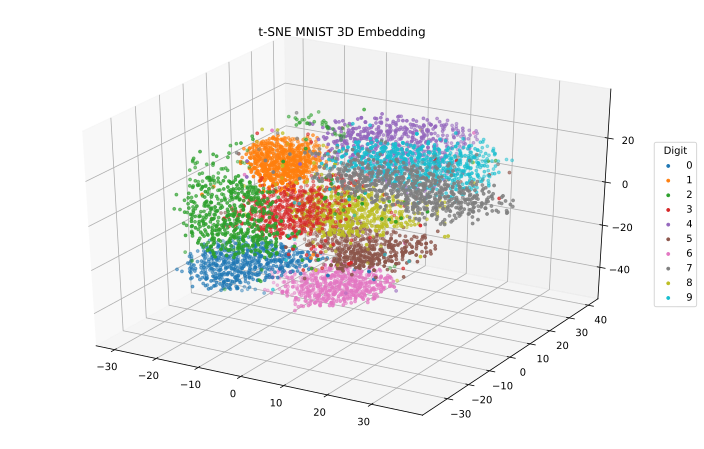

In [7]:
MNIST_tSNE = manifold.TSNE(n_components=3, perplexity=150, learning_rate=250, n_iter=2000).fit_transform(MNIST)

fig = plt.figure(figsize=(12,8))
ax = plt.axes(projection='3d')
for idx, group in enumerate(groups):
  ax.scatter(MNIST_tSNE[group, 0], MNIST_tSNE[group, 1], MNIST_tSNE[group, 2], label=idx, s=8)
ax.legend(title = "Digit", loc = "center right", borderaxespad=-2.)
plt.title("t-SNE MNIST 3D Embedding")
plt.show()

After much tuning, t-SNE was largely successful in seperating the MNIST data into clusters of the same digits which are largely disjoint from the other digit clusters.

## Problem 3

### Part A

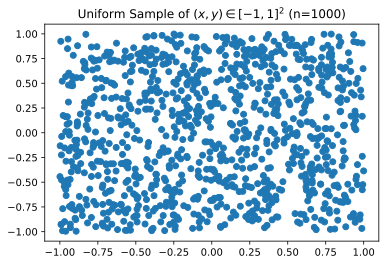

In [8]:
points = np.random.uniform(-1., 1., (1000,2))

plt.scatter(points[:,0], points[:,1])
plt.title("Uniform Sample of $(x,y) \in [-1,1]^2$ (n=1000)")
plt.show()

### Part B

In [0]:
Adjacency = kneighbors_graph(points, n_neighbors=30).toarray()
Adjacency_symmetric = np.maximum(Adjacency, Adjacency.T)

sigma = 1
Weighted_Adjacency = np.multiply(np.exp(-Adjacency_symmetric**2 / sigma**2), Adjacency_symmetric)
Weighted_Graph = nx.from_scipy_sparse_matrix(csgraph.csgraph_from_dense(Weighted_Adjacency))

### Part C

In [0]:
L_sym = nx.normalized_laplacian_matrix(Weighted_Graph)
vals, vecs = np.linalg.eigh(L_sym.A)

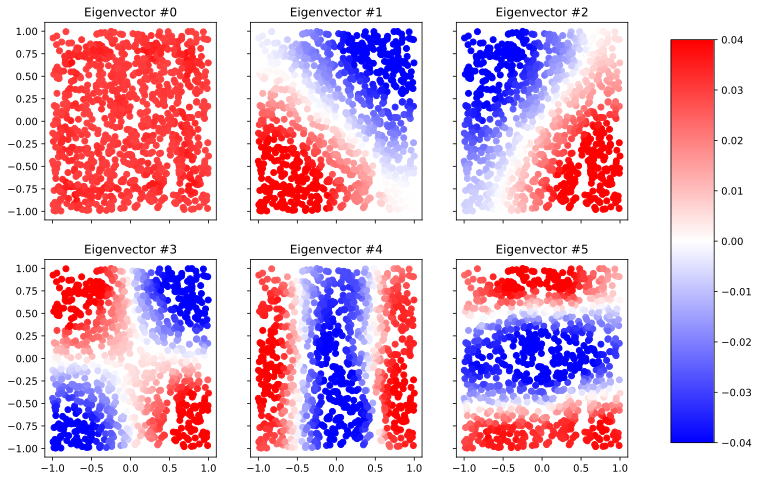

In [11]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12,8), sharex=True, sharey=True)
for idx, axes in enumerate(axes.flat):
    axes.set_title("Eigenvector #" + str(idx))
    ax = axes.scatter(points[:,0], points[:,1], c=vecs[:,idx], cmap='bwr', vmin=-0.04, vmax=0.04)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(ax, cax=cbar_ax)
plt.show()

### Part D

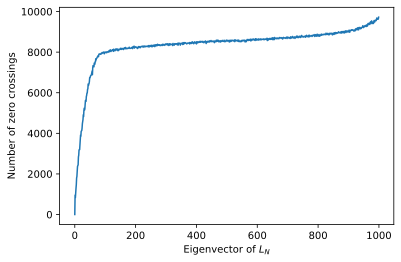

In [12]:
zero_crossings = np.zeros(1000)
for i in np.arange(1000):
  for edge in Weighted_Graph.edges:
    zero_crossings[i] += int(vecs[edge[0], i] * vecs[edge[1], i] < 0)

plt.plot(np.arange(1000), zero_crossings)
plt.xlabel("Eigenvector of $L_N$")
plt.ylabel("Number of zero crossings")
plt.show()

### Part E & F

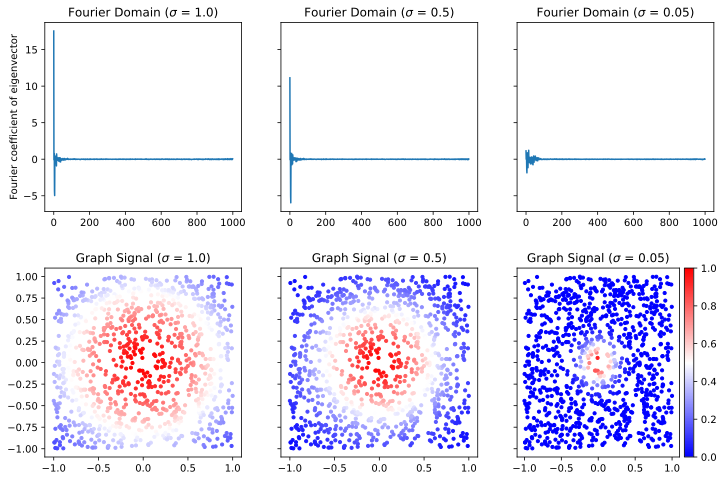

In [13]:
sigmas = np.array([1, 0.5, 0.05])

f, axes = plt.subplots(2, 3, figsize = (12, 8), sharey='row')
for idx, sigma in enumerate(sigmas):
  
  signal = [np.exp(-np.linalg.norm(point[0])**2 / sigma) for point in zip(points)]
  g = [np.dot(signal, vec) for vec in vecs.T]

  axes[0, idx].set_title("Fourier Domain ($\sigma$ = " + str(sigma) + ")")
  axes[0, idx].set_ylabel("Fourier coefficient of eigenvector" if idx == 0 else "")
  axes[0, idx].plot(np.arange(len(g)), g, c='C0')

  axes[1, idx].set_title("Graph Signal ($\sigma$ = " + str(sigma) + ")")
  im = axes[1, idx].scatter(points[:, 0], points[:, 1], c=signal, cmap='bwr', s=10, vmin=0., vmax=1.)

plt.subplots_adjust(hspace = 0.3)
fig.colorbar(im, ax=axes[1, 2], pad = 0.025)
plt.show()

### Part G & H

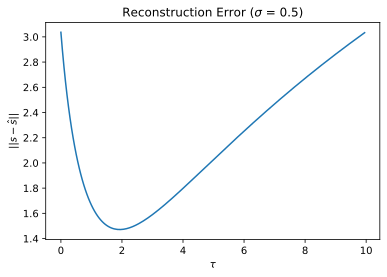

In [14]:
sigma = 0.5

signal = [np.exp(-np.linalg.norm(point[0])**2 / sigma) for point in zip(points)]
signal_tilde = signal + np.random.normal(scale=0.1, size=len(signal))

errors = np.array([])
for tau in np.arange(10, step=0.05):
  g_hat = [np.dot(signal_tilde, vec)/(1+tau*vals[idx]) for idx, vec in enumerate(vecs.T)]
  s_hat = np.zeros(shape=(1000,))
  for idx in np.arange(1000):
    s_hat += g_hat[idx]*vecs[:, idx]
  error = np.linalg.norm(signal - s_hat)
  errors = np.append(errors, error)

plt.plot(np.arange(10, step=0.05), errors)
plt.title("Reconstruction Error ($\sigma$ = " + str(sigma) + ")")
plt.xlabel("$\\tau$")
plt.ylabel("$||s - \hat{s}||$")
plt.show()